In [4]:
!pip install matplotlib
!pip install pandas
!pip install scikit-learn

  Using cached matplotlib-3.9.4-cp39-cp39-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp39-cp39-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp39-cp39-win_amd64.whl.metadata (103 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-11.1.0-cp39-cp39-win_amd64.whl.metadata (9.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.9.4-cp39-cp39-win_amd64.whl (7.8 MB)
Using cached contourpy-1.3.0-cp39-cp39-win_amd64.whl (211 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.56.0-cp39-cp39-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.7-cp39-cp39-win_amd64.whl (55 kB)
Using cached pillow-11.1.0-cp39-cp39-win_amd64.whl (2.6 MB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
  Using cached pandas-2.2.3-cp39-cp39-win_amd64.whl.metadata (19 kB)
  Using cached tzd

In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import pandas as pd
import time
from tensorflow.keras.applications import DenseNet169, InceptionV3, Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, matthews_corrcoef
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization


In [2]:
def center_crop(image, target_size=(256, 256)):
    h, w, _ = image.shape
    start_x = (w - target_size[0]) // 2
    start_y = (h - target_size[1]) // 2
    return image[start_y:start_y + target_size[1], start_x:start_x + target_size[0]]


In [10]:
def process_and_augment_data(source_dir, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        shear_range=0.2,
        zoom_range=0.2
    )
    
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        target_class_path = os.path.join(target_dir, class_name)
        os.makedirs(target_class_path, exist_ok=True)
        
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            image = cv2.imread(img_path)
            if image is None:
                continue
            
            image = center_crop(image)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = np.expand_dims(image, axis=0)  # Add batch dimension
            
            aug_iter = datagen.flow(image, batch_size=1)
            aug_image = next(aug_iter)[0].astype(np.uint8)
            
            save_path = os.path.join(target_class_path, img_name)
            cv2.imwrite(save_path, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
       

In [7]:
train_source = r'C:\Users\Chaitanya\Desktop\DL_project\DL221AI015\DL221AI015\DLai015\Dataset of groundnut plant leaf images for classification and detection\Dataset of groundnut plant leaf images for classification and detection\Groundnut_Leaf_dataset\Groundnut_Leaf_dataset\train'
test_source = r'C:\Users\Chaitanya\Desktop\DL_project\DL221AI015\DLai015\Dataset of groundnut plant leaf images for classification and detection\Dataset of groundnut plant leaf images for classification and detection\Groundnut_Leaf_dataset\Groundnut_Leaf_dataset\test'
train_target = 'processed_train'
test_target = 'processed_test'


In [5]:
process_and_augment_data(train_source, train_target)
process_and_augment_data(test_source, test_target)


In [8]:
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(train_target, target_size=(256, 256), batch_size=8, class_mode='categorical')
test_generator = datagen.flow_from_directory(test_target, target_size=(256, 256), batch_size=8, class_mode='categorical')


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'processed_train'

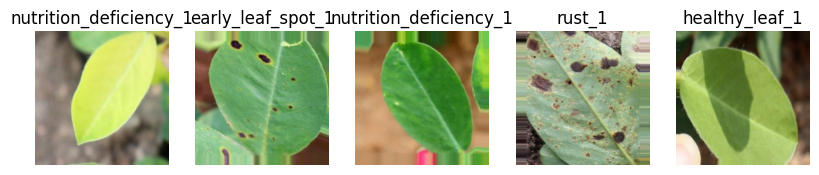

In [7]:
import matplotlib.pyplot as plt
import random

# Function to load and display images
def display_images(directory, num_images=5):
    class_folders = [os.path.join(directory, c) for c in os.listdir(directory)]
    class_folders = [c for c in class_folders if os.path.isdir(c)]  # Filter only directories
    
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        class_folder = random.choice(class_folders)
        image_name = random.choice(os.listdir(class_folder))
        image_path = os.path.join(class_folder, image_name)
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(os.path.basename(class_folder))
    
    plt.show()

# Display images from the processed training dataset
display_images('processed_train', num_images=5)


In [8]:
from tensorflow.keras.applications import DenseNet169, InceptionV3, Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [9]:
# Load pretrained models
input_shape = (256, 256, 3)
densenet = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
xception = Xception(weights='imagenet', include_top=False, input_shape=input_shape)


51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [10]:
# Freeze base models
densenet.trainable = False
inception.trainable = False
xception.trainable = False


In [11]:
def create_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(train_generator.num_classes, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=output)


In [12]:

model_densenet = create_model(densenet)
model_inception = create_model(inception)
model_xception = create_model(xception)


In [13]:
# Ensemble model averaging
inputs = tf.keras.Input(shape=input_shape)
outputs_densenet = model_densenet(inputs)
outputs_inception = model_inception(inputs)
outputs_xception = model_xception(inputs)
averaged_output = tf.keras.layers.Average()([outputs_densenet, outputs_inception, outputs_xception])
ensemble_model = Model(inputs=inputs, outputs=averaged_output)


In [14]:
# Compile the model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Precision, Recall
ensemble_model.compile(
    optimizer=RMSprop(learning_rate=2.00E-05),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Train the model
start_time = time.time()
history = ensemble_model.fit(train_generator, validation_data=test_generator, epochs=20)
training_time = time.time() - start_time


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


989/989 ━━━━━━━━━━━━━━━━━━━━ 212s 162ms/step - accuracy: 0.5981 - loss: 1.2405 - precision: 0.8806 - recall: 0.1410 - val_accuracy: 0.9376 - val_loss: 0.4964 - val_precision: 0.9985 - val_recall: 0.8095
Epoch 2/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 101s 102ms/step - accuracy: 0.8676 - loss: 0.5568 - precision: 0.9351 - recall: 0.7218 - val_accuracy: 0.9588 - val_loss: 0.3147 - val_precision: 0.9949 - val_recall: 0.8841
Epoch 3/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 101s 102ms/step - accuracy: 0.8892 - loss: 0.4188 - precision: 0.9273 - recall: 0.8252 - val_accuracy: 0.9616 - val_loss: 0.2546 - val_precision: 0.9801 - val_recall: 0.9225
Epoch 4/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 101s 102ms/step - accuracy: 0.9111 - loss: 0.3441 - precision: 0.9405 - recall: 0.8654 - val_accuracy: 0.9820 - val_loss: 0.2140 - val_precision: 0.9923 - val_recall: 0.9457
Epoch 5/20
989/989 ━━━━━━━━━━━━━━━━━━━━ 101s 102ms/step - accuracy: 0.9226 - loss: 0.3019 - precision: 0.9431 - recall: 0.8888 - val_accuracy: 0.9755 - val

In [15]:
# Display parameters layer-by-layer
for layer in ensemble_model.layers:
    print(f"Layer: {layer.name}, Trainable: {layer.trainable}")
    for param in layer.weights:
        print(f"  - {param.name}: {param.shape}")


Layer: input_layer_3, Trainable: True
Layer: functional, Trainable: True
  - kernel: (7, 7, 3, 64)
  - gamma: (64,)
  - beta: (64,)
  - moving_mean: (64,)
  - moving_variance: (64,)
  - gamma: (64,)
  - beta: (64,)
  - moving_mean: (64,)
  - moving_variance: (64,)
  - kernel: (1, 1, 64, 128)
  - gamma: (128,)
  - beta: (128,)
  - moving_mean: (128,)
  - moving_variance: (128,)
  - kernel: (3, 3, 128, 32)
  - gamma: (96,)
  - beta: (96,)
  - moving_mean: (96,)
  - moving_variance: (96,)
  - kernel: (1, 1, 96, 128)
  - gamma: (128,)
  - beta: (128,)
  - moving_mean: (128,)
  - moving_variance: (128,)
  - kernel: (3, 3, 128, 32)
  - gamma: (128,)
  - beta: (128,)
  - moving_mean: (128,)
  - moving_variance: (128,)
  - kernel: (1, 1, 128, 128)
  - gamma: (128,)
  - beta: (128,)
  - moving_mean: (128,)
  - moving_variance: (128,)
  - kernel: (3, 3, 128, 32)
  - gamma: (160,)
  - beta: (160,)
  - moving_mean: (160,)
  - moving_variance: (160,)
  - kernel: (1, 1, 160, 128)
  - gamma: (128,)
 

In [16]:
# Save the trained model
ensemble_model.save('ensemble_model.h5')

# Print model summary and parameters
ensemble_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 6)              │     13,498,438 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ (None, 6)              │     22,854,950 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_2 (Functional) │ (None, 6)              │     21,913,646 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average (Average)         │ (None, 6)              │              0 │ functional[0][0],      │
│                           │                        │                │ functional_1[0][0],    │
│                           │                        │                │ functional_2[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 61,226,926 (233.56 MB)

 Trainable params: 2,959,890 (11.29 MB)

 Non-trainable params: 55,307,144 (210.98 MB)

 Optimizer params: 2,959,892 (11.29 MB)

In [17]:
print(type(test_generator))

<class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>


In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Load trained model
ensemble_model = tf.keras.models.load_model("ensemble_model.h5")

# List of functional sub-models
functional_models = ["functional", "functional_1", "functional_2"]

# Extract BatchNorm layers (Limit to 3 layers per sub-model)
bn_layers_dict = {}
max_bn_layers = 3 

for func_name in functional_models:
    sub_model = ensemble_model.get_layer(func_name)
    bn_layers = [layer.name for layer in sub_model.layers if isinstance(layer, tf.keras.layers.BatchNormalization)]
    bn_layers_dict[func_name] = bn_layers[:max_bn_layers]  # Limit to 3 BN layers

# Ensure test_generator exists and get a batch
test_batch = next(iter(test_generator))[0]  # Extract only input images

# Create a directory to save plots
os.makedirs("bn_plots", exist_ok=True)

# Extract BN activations for Epochs 1 to 5
for epoch in range(1, 6):  # Runs for epochs 1, 2, 3, 4, 5
    print(f"\nExtracting Batch Normalization activations for Epoch {epoch}...")

    for func_name, bn_layers in bn_layers_dict.items():
        sub_model = ensemble_model.get_layer(func_name)

        for i, layer_name in enumerate(bn_layers):
            try:
                # Get Batch Normalization layer
                bn_layer = sub_model.get_layer(layer_name)

                # Temporarily unfreeze BN layer
                bn_layer.trainable = True  

                # Create an intermediate model to extract BN activations
                intermediate_model = tf.keras.Model(
                    inputs=sub_model.input,  # Correct input reference
                    outputs=bn_layer.output
                )

                # Run forward pass with `training=True` to capture BN statistics
                normalized_values = intermediate_model(test_batch, training=True)
                flattened_values = normalized_values.numpy().reshape(normalized_values.shape[0], -1)

                # Re-freeze BN layer after extraction
                bn_layer.trainable = False  

                # Plot the BN activations (LIMIT TO 3 SAMPLES MAX)
                plt.figure(figsize=(12, 6))
                for j in range(min(flattened_values.shape[0], 3)):  # Only plot 3 samples
                    plt.plot(flattened_values[j])

                plt.xlabel("Feature Index")
                plt.ylabel("Normalized Value")
                plt.title(f"Epoch {epoch} - BN Activations - {func_name} - {layer_name}")
                plt.grid(True)

                # Save the plot
                filename = f"bn_plots/epoch{epoch}_bn_{func_name}_{layer_name}.jpeg"
                plt.savefig(filename)
                plt.close()

                print(f"Saved: {filename}")

            except KeyError as e:
                print(f"Skipping {layer_name} in {func_name} due to KeyError: {e}")
            except Exception as e:
                print(f"Error processing {func_name} - {layer_name}: {e}")


Extracting Batch Normalization activations for Epoch 1...
Saved: bn_plots/epoch1_bn_functional_conv1_bn.jpeg
Saved: bn_plots/epoch1_bn_functional_conv2_block1_0_bn.jpeg
Saved: bn_plots/epoch1_bn_functional_conv2_block1_1_bn.jpeg
Saved: bn_plots/epoch1_bn_functional_1_batch_normalization.jpeg
Saved: bn_plots/epoch1_bn_functional_1_batch_normalization_1.jpeg
Saved: bn_plots/epoch1_bn_functional_1_batch_normalization_2.jpeg
Saved: bn_plots/epoch1_bn_functional_2_block1_conv1_bn.jpeg
Saved: bn_plots/epoch1_bn_functional_2_block1_conv2_bn.jpeg
Saved: bn_plots/epoch1_bn_functional_2_block2_sepconv1_bn.jpeg

Extracting Batch Normalization activations for Epoch 2...
Saved: bn_plots/epoch2_bn_functional_conv1_bn.jpeg
Saved: bn_plots/epoch2_bn_functional_conv2_block1_0_bn.jpeg
Saved: bn_plots/epoch2_bn_functional_conv2_block1_1_bn.jpeg
Saved: bn_plots/epoch2_bn_functional_1_batch_normalization.jpeg
Saved: bn_plots/epoch2_bn_functional_1_batch_normalization_1.jpeg
Saved: bn_plots/epoch2_bn_funct

In [19]:
# Evaluate on test data
start_test_time = time.time()
y_true = test_generator.classes
y_pred_probs = ensemble_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
testing_time = time.time() - start_test_time


307/307 ━━━━━━━━━━━━━━━━━━━━ 54s 120ms/step


In [20]:

# Compute metrics
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys(), output_dict=True)
conf_matrix = confusion_matrix(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)


In [21]:
# Save evaluation results
results_df = pd.DataFrame(report).transpose()
results_df['MCC'] = mcc
results_df.to_excel('gagan-221ai019-prediction.xlsx', index=False)


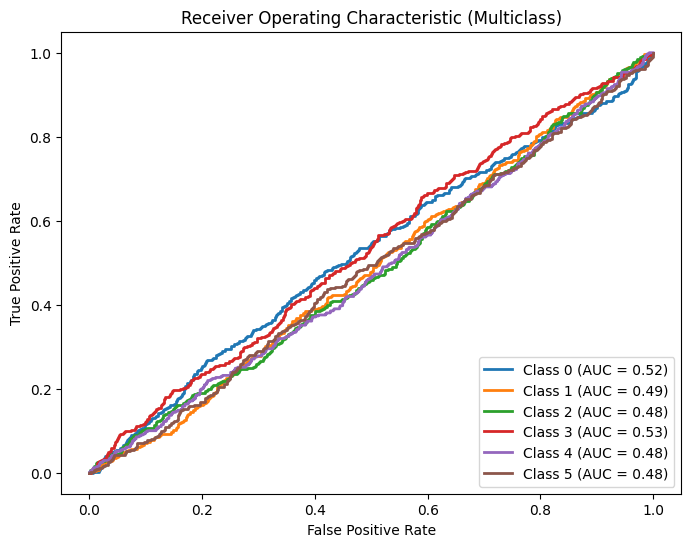

In [ ]:
from sklearn.preprocessing import label_binarize

# Binarize the output labels for one-vs-rest ROC computation
y_true_bin = label_binarize(y_true, classes=list(range(train_generator.num_classes)))

# Compute ROC curve and AUC for each classx
plt.figure(figsize=(8, 6))
for i in range(train_generator.num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Multiclass)')
plt.legend(loc='lower right')
plt.savefig('gagan-221AI019-roc.jpeg')
plt.show()


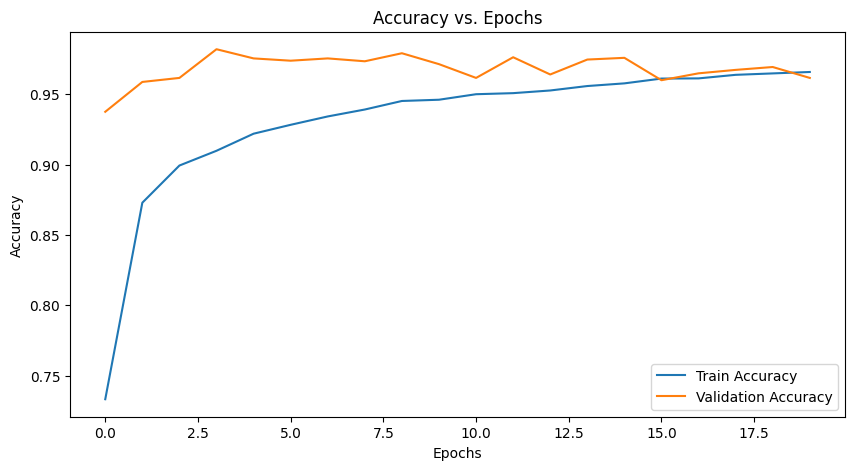

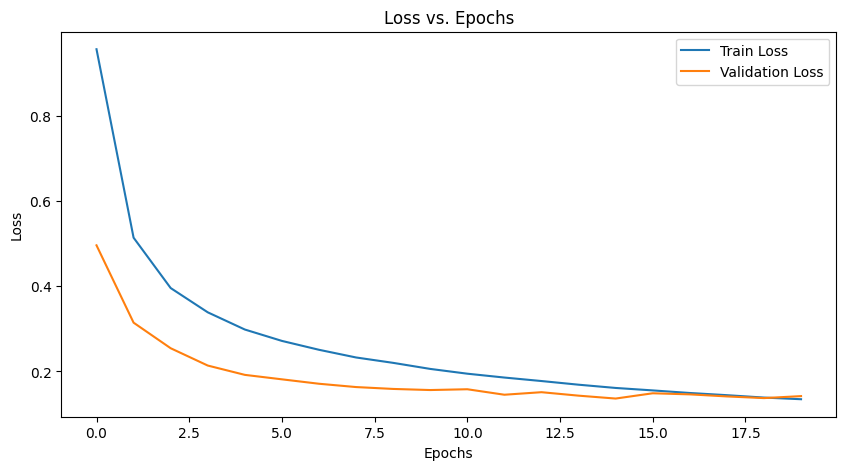

In [23]:
# Plot Accuracy and Loss Graphs
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')
plt.savefig('gagan-221AI019-accuracygraph.jpeg')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')
plt.savefig('gagan-221AI019-lossgraph.jpeg')
plt.show()


In [24]:
# Save training and testing time
time_results = pd.DataFrame({
    'Training Time (s)': [training_time],
    'Testing Time (s)': [testing_time]
})
time_results.to_excel('gagan-221AI019-trainingtime.xlsx', index=False)


In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)


2.19.0
3.9.1


In [13]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects

from tensorflow.keras.models import load_model

# Load without compiling
model = load_model(r"C:\Users\Chaitanya\Desktop\DL_project\DL221AI015\DL221AI015\DLai015\ensemble_model.h5", compile=False)

# Resave the model with a fixed format
model.save("fixed_ensemble_model.h5")

model = load_model("ensemble_model.h5", custom_objects=get_custom_objects())


# Load class labels dynamically from train generator
#class_labels = list(test_generator.class_indices.keys())  # Ensure test_generator is defined
class_labels = ['early_leaf_spot_1',
 'early_rust_1',
 'healthy_leaf_1',
 'late_leaf_spot_1',
 'nutrition_deficiency_1',
 'rust_1']
def predict_image(image_path):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to read image.")
        return None
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    image = img_to_array(image) / 255.0  # Ensure same normalization as training
    image = np.expand_dims(image, axis=0)
    
    # Make prediction
    predictions = model.predict(image)  # Ensure batch norm is in inference mode
    probabilities = tf.nn.softmax(predictions).numpy()  # Convert logits to probabilities
    predicted_class = np.argmax(probabilities)
    confidence = probabilities[0][predicted_class]
    
    print(f"Predicted Class: {class_labels[predicted_class]} (Confidence: {confidence:.2f})")

# Example usage
image_path = r"C:\Users\Chaitanya\Desktop\DL_project\DL221AI015\DL221AI015\DLai015\Dataset of groundnut plant leaf images for classification and detection\Dataset of groundnut plant leaf images for classification and detection\Raw_Data\late leaf spot\IMG_3128.JPG"
predict_image(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step
Predicted Class: late_leaf_spot_1 (Confidence: 0.23)
